In [1]:
using LinearAlgebra, Plots, Test

### MATH50003 Week 7 Lecture Notes (before Fourier Series)

**Two-point boundary value problems with Poisson equation**

Here we will only consider one discretisation as it is symmetric:
$$
u''(x_k) ≈ {u_{k-1} - 2u_k + u_{k+1} \over h^2}
$$
That is we use the $n-1 × n+1$ matrix:
$$
D_h^2 := {1 \over h^2} \begin{bmatrix}
1 & -2 & 1 \\ & ⋱ & ⋱ & ⋱ \\
&& 1 & -2 & 1 
\end{bmatrix}
$$

And we need to add our intial value boundaries to get the square matrix.
$$
\begin{bmatrix}
𝐞_1^⊤ \\
D_h^2 \\
𝐞_{n+1}^⊤
\end{bmatrix}
$$

### Example Question
 test convergence on $u(x) = \cos x^2$ which satisfies
$$
\begin{align*}
u(0) = 1 \\
u(1) = \cos 1 \\
u''(x) = -4x^2*cos(x^2) - 2sin(x^2)
\end{align*}
$$
We observe uniform ($∞$-norm) convergence: (Notice how two value problem is implemented beblow)

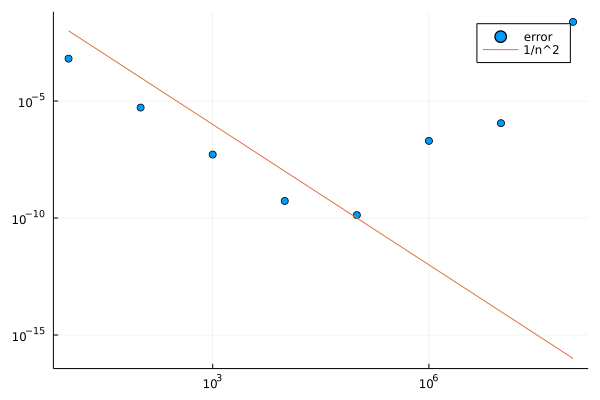

In [39]:
function poisson_err(u, c0, c1, f, n)
    x = range(0,1; length = n)
    h = step(x)

    T = Tridiagonal([fill(1/h^2, n-2);0], [1; fill(-2/h^2, n-2); 1], [0; fill(1/h^2, n-2)])
    uᶠ = T \ [c0; f.(x[2:end-1]); c1]

    norm(uᶠ - u.(x), Inf)
end

# Now we implement another version using SymTridiagonal (faster)
function poisson_err2(u, c0, c1, f, n)
    x = range(0,1; length = n)
    h = step(x)

    Δ = SymTridiagonal(fill(-2/h^2, n-2), fill(1/h^2, n-3)) # We discard the boundary values first
    ũᶠ = Δ \ [f(x[2]) - c0/h^2; f.(x[3:end-2]); f(x[end-1]) - c1/h^2]
    uᶠ = [c0; ũᶠ; c1]

    norm(uᶠ - u.(x), Inf)
end

u = x -> cos(x^2)
f = x -> -4x^2 * cos(x^2) - 2sin(x^2)

ns = 10 .^ (1:8)
scatter(ns, poisson_err2.(u, 1, cos(1), f, ns); xscale=:log10, yscale=:log10, label="error")
plot!(ns, ns .^ (-2); label="1/n^2")

### Another Example Question

Construct a finite-difference approximation to the
forced Helmholtz equation
$$
\begin{align*}
u(0) &= 0 \\
u(1) &= 0 \\
u'' + k^2 u &= {\rm e}^x
\end{align*}
$$
and find an $n$ such  the error is less than $10^{-4}$ when compared
with the true solution for $k=10$:
$$
u(x) = (-\cos(k x) + {\rm e}^x \cos(k x)^2 + \cot(k) \sin(k x) - {\rm e} \cos(k) \cot(k) \sin(k x) - {\rm e} \sin(k) \sin(k x) + {\rm e}^x \sin(k x)^2)/(1 + k^2)
$$

In [2]:
function helm(k, n)
    x = range(0, 1; length = n)
    h = step(x)
    # TODO: Create a SymTridiagonal discretisation
    T = SymTridiagonal(fill(k^2-2/h^2, n-2), fill(1/h^2, n-3))
    ũ = T \ [exp(x[2]); exp.(x[3:end-2]); exp(x[end-1])]
    u = [0; ũ; 0]
end

k = 10
u = x -> (-cos(k*x) + exp(x)cos(k*x)^2 + cot(k)sin(k*x) - ℯ*cos(k)cot(k)sin(k*x) - ℯ*sin(k)sin(k*x) + exp(x)sin(k*x)^2)/(1 + k^2)

n = 10_000 # TODO: choose n to get convergence
x = range(0, 1; length=n)
@test norm(helm(k, n) - u.(x)) ≤ 1E-4

Test Passed
  Expression: norm(helm(k, n) - u.(x)) ≤ 0.0001
   Evaluated: 3.2770124444939947e-6 ≤ 0.0001

### (hopefully) Last Example Question
 Discretisations can also be used to solve eigenvalue equations.
Consider the Schrödinger equation with quadratic oscillator:
$$
u(-L) = u(L) = 0, -u'' + x^2 u = λ u
$$
Approximate the eigenvalues using `eigvals(A)` (which returns the eigenvalues of a
matrix `A`) with $L = 10$.
Can you conjecture their exact value if $L = ∞$? (Hint: they are integers and the eigenvalues
closest to zero are most accurate.)

In [53]:
L = 10
n = 1000
x = range(-L, L; length = n)
h = step(x)

eigvals(SymTridiagonal(fill(2/h^2, n-2) + x[2:end-1].^2, fill(-1/h^2, n-3))) # Notice the changes of signs due to -u''

998-element Vector{Float64}:
     0.9999749492977316
     2.999874743976697
     4.999674327058133
     6.999373691007382
     8.998972828286286
    10.99847173136418
    12.997870392696692
    14.997168804739214
    16.9963669599553
    18.995464850797372
    20.99446246971592
    22.99335980916551
    24.992156861590303
     ⋮
 10020.084643187867
 10020.08464318788
 10026.484841478732
 10026.484841478743
 10033.606931820945
 10033.606931820945
 10041.682004542276
 10041.68200454228
 10051.156993554187
 10051.156993554216
 10063.190188090453
 10063.190188090477

### Convergence for forward and backward euler

Consider the equation
$$
u(0) = c, u'(t) + a u(t) = f(t)
$$
Denote
$$
𝐮 := \begin{bmatrix} u(t_1) \\ ⋮ \\ u(t_n) \end{bmatrix}
$$
Assume that $u$ is twice-differentiable with uniformly bounded
second derivative.
Then the error for forward/backward Euler is
$$
\|𝐮ᶠ - 𝐮\|_∞, \|𝐮ᵇ - 𝐮\|_∞ = O(n^{-1})
$$
which means the error goes to 0 as n tends to infinity.

### Convergence for Poisson

 Suppose that $u$ is four-times differentiable with uniformly
bounded fourth derivative. Then the finite difference approximation to Poisson converges like $O(n^2)$.